<a href="https://colab.research.google.com/github/MarcoC1796/recommender-systems-thesis/blob/main/LatentFactorWithMovieDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys, importlib

user = "MarcoC1796"
repo = "recommender-systems-thesis"
src_dir = "src"

if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{user}/{repo}.git

path = f"{repo}"
if not path in sys.path:
    sys.path.append(path)

Cloning into 'recommender-systems-thesis'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 211 (delta 70), reused 65 (delta 38), pack-reused 110
Receiving objects: 100% (211/211), 97.73 MiB | 18.15 MiB/s, done.
Resolving deltas: 100% (120/120), done.
Updating files: 100% (25/25), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tqdm.auto import trange, tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.LatentFactorsCollabortiveFiltering import LatentFactorsCollaborativeFiltering

plt.style.use("ggplot")

In [4]:
path = "/content/drive/MyDrive/Thesis/Data/"
path += "ml-1m/ratings.dat"

rnames = ["user_id", "movie_id", "rating", "timestamp"]
movies = pd.read_table(path, sep="::", header=None, names=rnames, engine="python")
movies = movies.drop('timestamp', axis=1)


movies_im = pd.pivot_table(movies, values="rating", index="user_id", columns="movie_id")
movies_im.reset_index(drop=True, inplace=True)
movies_im.columns = range(movies_im.shape[1])
movies_im.rename_axis("user_id", axis="index", inplace=True)
movies_im.rename_axis("item_id", axis="columns", inplace=True)

stacked_series = movies_im.stack().dropna()
transformed_df = stacked_series.reset_index()
transformed_df.columns = ['user_id', 'item_id', 'rating']

R = movies_im.to_numpy()
print(f"R has {round((np.count_nonzero(~np.isnan(R))/R.size)*100, 2)}% of full entries")

movies_array = transformed_df[['user_id', 'item_id', 'rating']].values

train_val_set, test_set = train_test_split(movies_array, test_size=0.2, random_state=42)
print(f"Shape of training set: {train_val_set.shape}")
print(f"Shape of test set: {test_set.shape}")

R has 4.47% of full entries
Shape of training set: (800167, 3)
Shape of test set: (200042, 3)


In [ ]:
num_factors_list = [0,1,2] + list(range(5,101,5))
train_errors_result = []
val_errors_result = []
train_errors_result_bias = []
val_errors_result_bias = []
models = []
models_bias = []

pbar = tqdm(num_factors_list)
for num_factors in pbar:
  pbar.set_description(f"Current Factors: {num_factors} | Progress")
  #model = LatentFactorsCollaborativeFiltering(R.shape[0], R.shape[1], include_biases=False)
  #train_errors, val_errors = model.fit(train_interactions=train_val_set, num_factors=num_factors,validation_interactions=test_set, epochs=20, batch_size=32, learning_rate=1e-2)
  #train_errors_result.append(train_errors)
  #val_errors_result.append(val_errors)
  #models.append(model)
  model = LatentFactorsCollaborativeFiltering(R.shape[0], R.shape[1])
  reg = 0
  learning_rate = 1e-2
  if num_factors > 100:
    learning_rate = 1e-3
  train_errors, val_errors = model.fit(train_interactions=train_val_set, num_factors=num_factors,validation_interactions=test_set, epochs=20, batch_size=512, learning_rate=learning_rate,reg_strength=reg)
  train_errors_result_bias.append(train_errors)
  val_errors_result_bias.append(val_errors)
  models_bias.append(model)

In [ ]:
num_factors_list = np.logspace(base=10,start=-2,stop=-1,num=5)
train_errors_result = []
val_errors_result = []
train_errors_result_bias = []
val_errors_result_bias = []
models = []
models_bias = []

pbar = tqdm(num_factors_list)
for num_factors in pbar:
  pbar.set_description(f"Current Factors: {num_factors} | Progress")
  #model = LatentFactorsCollaborativeFiltering(R.shape[0], R.shape[1], include_biases=False)
  #train_errors, val_errors = model.fit(train_interactions=train_val_set, num_factors=num_factors,validation_interactions=test_set, epochs=20, batch_size=32, learning_rate=1e-2)
  #train_errors_result.append(train_errors)
  #val_errors_result.append(val_errors)
  #models.append(model)
  model = LatentFactorsCollaborativeFiltering(R.shape[0], R.shape[1])
  train_errors, val_errors = model.fit(train_interactions=train_val_set, num_factors=100,validation_interactions=test_set, epochs=8, batch_size=128, learning_rate=1e-2,reg_strength=num_factors)
  train_errors_result_bias.append(train_errors)
  val_errors_result_bias.append(val_errors)
  models_bias.append(model)

In [ ]:
from google.colab import files
import json

data_to_save = {
    "num_factors_list": num_factors_list,
    "train_errors_result_bias": train_errors_result_bias,
    "val_errors_result_bias":val_errors_result_bias
    # Add more data here
}
x = json.dumps (data_to_save)
y = x.encode('utf-8')
with open('example.txt', 'w') as f:
  f.write(str(y))

files.download('example.txt')

In [ ]:
variable_name = f'{num_factors_list=}'.split('=')[0]
print(variable_name)

In [ ]:
models[-1].item_embeddings[:,-5:]

In [ ]:
np.mean((models[-1].user_embeddings @ models[-1].item_embeddings.T))

In [ ]:

# Uncomment the following line to adjust the figure size if needed
# plt.figure(figsize=(8, 6))

biases = True

# Define a list of line styles, markers, and colors
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'v']
colors = sns.color_palette('husl', len(num_factors_list))

for idx, (num_factors, train_errors, val_errors) in enumerate(zip(num_factors_list, train_errors_result_bias, val_errors_result_bias)):
    list1 = train_errors
    list2 = val_errors
    # Choose a distinct line style, marker, and color for each line
    line_style = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]
    color = colors[idx % len(colors)]
    
    # Plotting the lists with distinct line style, marker, and color
    #plt.plot(list1[-4:], label=f'Training error | factors={num_factors} | biases={biases}', linestyle=line_style, marker=marker, color=color)
    plt.plot(list2[-4:], label=f'Validation error | factors={num_factors} | biases={biases}', linestyle=line_style, marker=marker, color=color)

# Move the legend outside the plot area
plt.legend(bbox_to_anchor=(1.02, 0.5), loc='center left')

plt.show()

In [ ]:
i = 1
min_train_errors = [min(val_errors) for val_errors in train_errors_result_bias]
min_val_errors= [min(val_errors) for val_errors in val_errors_result_bias]
plt.plot(num_factors_list[:], min_train_errors, label="train")
plt.plot(num_factors_list[:], min_val_errors, label = "val")
plt.legend()
plt.show()
print(num_factors_list[np.argmin(min_val_errors)])

In [ ]:
list1 = train_errors_result_bias[0]
list2= val_errors_result_bias[0]
# Plotting the lists
plt.plot(list1, label='List 1')
plt.plot(list2, label='List 2')

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Plot')

# Adding annotations for minimum values
min_value1 = min(list1)
min_value2 = min(list2)

plt.annotate(f'Min: {min_value1:.2f}', xy=(list1.index(min_value1), min_value1),
             xytext=(10, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

plt.annotate(f'Min: {min_value2:.2f}', xy=(list2.index(min_value2), min_value2),
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

# Highlighting the minimum value points
plt.scatter(list1.index(min_value1), min_value1, color='red', zorder=10)
plt.scatter(list2.index(min_value2), min_value2, color='red', zorder=10)

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
(models[1].user_embeddings @ models[1].item_embeddings.T)[~np.isnan(R)].max()

In [ ]:
models[1].item_embeddings[:,2].max()

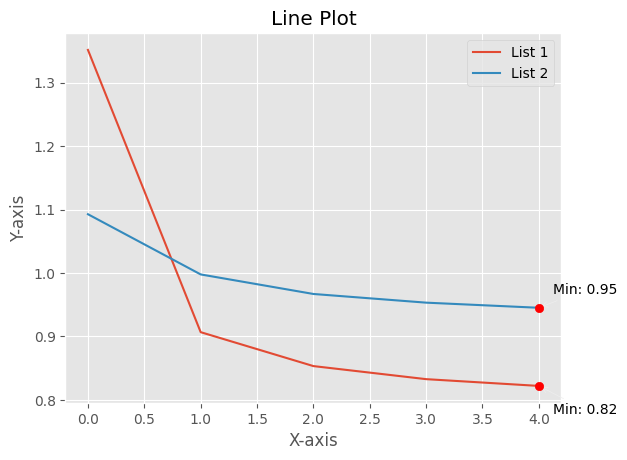

In [22]:
list1 = train_errors
list2 = val_errors

# Plotting the lists
plt.plot(list1, label='List 1')
plt.plot(list2, label='List 2')

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Plot')

# Adding annotations for minimum values
min_value1 = min(list1)
min_value2 = min(list2)

plt.annotate(f'Min: {min_value1:.2f}', xy=(list1.index(min_value1), min_value1),
             xytext=(10, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

plt.annotate(f'Min: {min_value2:.2f}', xy=(list2.index(min_value2), min_value2),
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

# Highlighting the minimum value points
plt.scatter(list1.index(min_value1), min_value1, color='red', zorder=10)
plt.scatter(list2.index(min_value2), min_value2, color='red', zorder=10)

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
from src.aux_functions import standardize_interactions
import inspect
lines = inspect.getsource(LatentFactorsCollaborativeFiltering)
print(lines)

In [ ]:
a = np.array([1, 2, 3, 4])
indices = np.array([0, 1, 0, 1])
values = np.array([10, 20, 30, 40])
np.add.at(a, indices, values)
print(a)

In [ ]:
a = np.array([1, 2, 3, 4])
indices = np.array([0, 1, 0, 1])
values = np.array([10, 20, 30, 40])
a[indices] += values
print(a)

In [70]:
model = LatentFactorsCollaborativeFiltering(R.shape[0], R.shape[1])
train_errors, val_errors = model.fit(train_interactions=train_val_set, 
                                     num_factors=10,
                                     epochs=5, 
                                     batch_size=64, 
                                     learning_rate=0.01,
                                     reg_strength=0)

RMSE: None | Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/12503 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/12503 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/12503 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/12503 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/12503 [00:00<?, ?it/s]

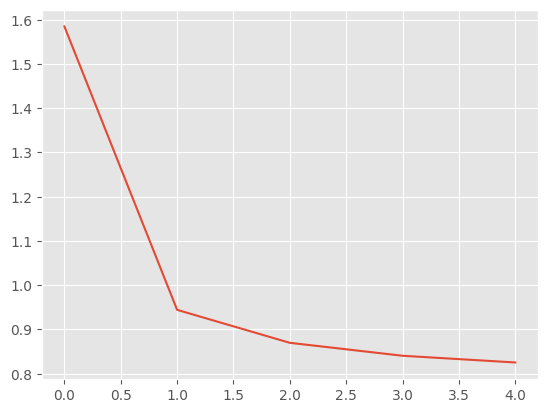

In [71]:
plt.plot(train_errors)
plt.show()

In [66]:
train_errors

[1.5932637178424072]

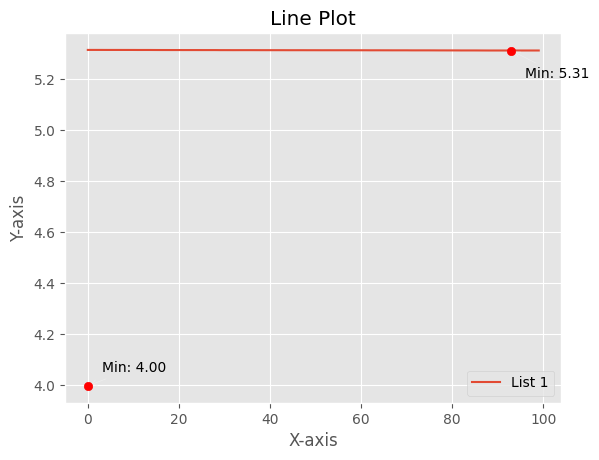

In [54]:
list1 = train_errors
list2 = val_errors

# Plotting the lists
plt.plot(list1, label='List 1')
#plt.plot(list2, label='List 2')

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Line Plot')

# Adding annotations for minimum values
min_value1 = min(list1)
min_value2 = min(list2)

plt.annotate(f'Min: {min_value1:.2f}', xy=(list1.index(min_value1), min_value1),
             xytext=(10, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

plt.annotate(f'Min: {min_value2:.2f}', xy=(list2.index(min_value2), min_value2),
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->"))

# Highlighting the minimum value points
plt.scatter(list1.index(min_value1), min_value1, color='red', zorder=10)
plt.scatter(list2.index(min_value2), min_value2, color='red', zorder=10)

# Adding legend
plt.legend()

# Display the plot
plt.show()